In [ ]:
# Importing libraries
from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json
import os
from OSCC_postprocessing.filters.bilateral_filter import *
from OSCC_postprocessing.binary_ops.functions_bw import *
from OSCC_postprocessing.analysis.multihole_utils import * 
import cupy as cp
from OSCC_postprocessing.analysis.single_plume import _binary_fill_holes_gpu
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect, generate_plume_mask
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)


import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )

warnings.filterwarnings("ignore", category=RuntimeWarning)
use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

global timing
timing = True

In [ ]:
def longest_true_run(mask):
    """返回最长 True 连续段的 (start, end_exclusive)，若无 True 返回 None。"""
    """Retruan the longest True duration"""
    m = mask.astype(bool)
    if not m.any():
        return None
    diff = xp.diff(m.astype(xp.int8))
    starts = xp.where(diff == 1)[0] + 1
    ends   = xp.where(diff == -1)[0] + 1
    if m[0]:
        starts = xp.r_[0, starts]
    if m[-1]:
        ends = xp.r_[ends, len(m)]
    lengths = ends - starts
    k = xp.argmax(lengths)
    return int(starts[k]), int(ends[k])

In [ ]:
def _get_cupy():
    """Return the CuPy module if available, otherwise ``None``."""
    try:
        import cupy as cp  # type: ignore

        return cp
    except Exception:
        return None

In [ ]:
def _as_numpy(arr):
    if USING_CUPY and hasattr(arr, "__cuda_array_interface__"):
        return cp.asnumpy(arr)
    return np.asarray(arr)


def to_py_scalar(x):
    # x 可能是 cupy scalar / cupy 0-d array / numpy scalar / python number
    if isinstance(x, cp.ndarray):
        return float(x.get().item())
    try:
        return float(x)
    except TypeError:
        # 兜底：比如 cupy scalar
        return float(cp.asarray(x).get().item())

In [ ]:


def mad(x):
    med = xp.median(x)
    return xp.median(xp.abs(x - med)) + 1e-12

def hysteresis_threshold(y, th_lo, th_hi):
    """
    滞回阈值：>th_hi 触发进入 high；<th_lo 退出 high。
    
    Hysteresis threshold:  
        When the value > th_hi, triggers high state;
        when the value < th_lo, exits high state
        """
    high = y > th_hi
    low  = y < th_lo

    mask = xp.zeros_like(y, dtype=bool)
    state = False
    for i in range(len(y)):
        if not state:
            if high[i]:
                state = True
        else:
            if low[i]:
                state = False
        mask[i] = state
    return mask

def fill_short_false_runs(mask, max_len=3):
    """
    把 mask 中短的 False 段填成 True（填洞）。
    Filling short False pulses into True (hole-filling)
    """
    m = mask.copy()
    # 找 False runs
    diff = xp.diff(m.astype(xp.int8))
    starts = xp.where(diff == -1)[0] + 1  # True->False 后 False 段开始
    ends   = xp.where(diff ==  1)[0] + 1  # False->True 后 False 段结束
    if m[0] == False:
        starts = xp.r_[0, starts]
    if m[-1] == False:
        ends = xp.r_[ends, len(m)]
    for s, e in zip(starts, ends):
        if (e - s) <= max_len:
            m[s:e] = True
    return m

def remove_short_true_runs(mask, min_len=5):
    """把 mask 中短的 True 段删掉（去小岛）。"""
    """Filling up short True pulses with False (removing islands)"""
    m = mask.copy()
    diff = xp.diff(m.astype(xp.int8))
    starts = xp.where(diff == 1)[0] + 1
    ends   = xp.where(diff == -1)[0] + 1
    if m[0] == True:
        starts = xp.r_[0, starts]
    if m[-1] == True:
        ends = xp.r_[ends, len(m)]
    for s, e in zip(starts, ends):
        if (e - s) < min_len:
            m[s:e] = False
    return m

def longest_true_run(mask):
    """返回最长 True 连续段的 (start, end_exclusive)，若无 True 返回 None。"""
    """Retruan the longest True duration"""
    m = mask.astype(bool)
    if not m.any():
        return None
    diff = xp.diff(m.astype(xp.int8))
    starts = xp.where(diff == 1)[0] + 1
    ends   = xp.where(diff == -1)[0] + 1
    if m[0]:
        starts = xp.r_[0, starts]
    if m[-1]:
        ends = xp.r_[ends, len(m)]
    lengths = ends - starts
    k = xp.argmax(lengths)
    return int(starts[k]), int(ends[k])

def detect_single_high_interval(y, x=None,
                                base_quantile=0.50,
                                scale_quantile=0.10,
                                k_hi=8.0, k_lo=4.0,
                                fill_hole_len=3,
                                min_island_len=5):
    """
    y: 1D 信号
    x: 可选真实坐标；不传则用索引
    阈值：th_hi = base + k_hi * sigma, th_lo = base + k_lo * sigma
    sigma 用 MAD 估计（鲁棒）

    y: 1D signal,
    x: Can accecpt real coordinates, 
    """
    y = xp.asarray(y)
    if x is None:
        x = xp.arange(len(y))
    else:
        x = xp.asarray(x)

    # 1) 基线与尺度（鲁棒）
    base = xp.quantile(y, base_quantile)
    sigma = 1.4826 * mad(y - base)  # MAD->std 等效（对高斯噪声）
    th_hi = base + k_hi * sigma
    th_lo = base + k_lo * sigma

    # 2) 滞回二值化
    mask = hysteresis_threshold(y, th_lo=th_lo, th_hi=th_hi)

    # 3) 清理：填洞 + 去小岛
    mask = fill_short_false_runs(mask, max_len=fill_hole_len)
    mask = remove_short_true_runs(mask, min_len=min_island_len)

    # 4) 只保留最长段
    run = longest_true_run(mask)
    if run is None:
        return None, mask, (th_lo, th_hi)

    s, e = run
    # 输出坐标：起点 x[s]，终点 x[e-1]（最后一个 True 的点）
    return (x[s], x[e-1], s, e-1), mask, (th_lo, th_hi)

In [ ]:
file = Path(r"G:\MeOH_test\Mie\T2_Mie Camera_1.cine")
json_file = Path(r"G:\MeOH_test\Mie\config.json")
out_dir = Path(r"G:\MeOH_test\Mie\Processed_Results")

save_name_stem = Path(file).stem

Path(out_dir/"Rotated_Videos").mkdir(parents= True, exist_ok=True)
Path(out_dir / "Postprocessed_Data").mkdir(parents=True, exist_ok=True)

save_path_video = out_dir / "Rotated_Videos"
save_path_data = out_dir / "Postprocessed_Data"



umbrella_angle=180.0
# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits

# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file)


F, H, W = video.shape

# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

# Normalize the grayscale video to [0, 1] brightness range
if use_gpu: 
    video = cp.asarray(video, dtype=cp.float16)     # 直接生成 float16，少一次 astype 临时
    video *= cp.float16(1.0 / brightness_levels)              # 就地，不产生新数组
else:
    video *= np.float16(1.0 / brightness_levels)


with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)

print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")

Video Info - Width: 768, Height: 768, Frames: 401
CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Py\\Mie_Postprocessing_Py\\.venv311\\Lib\\site-packages\\cupy\\__init__.py'>
The injector has 1 plumes.
The nozzle is centred at (604.00, 82.00) in image coordinates.


In [ ]:
play_video_cv2(_as_numpy(video), intv=17)

(604.0, 82.0)

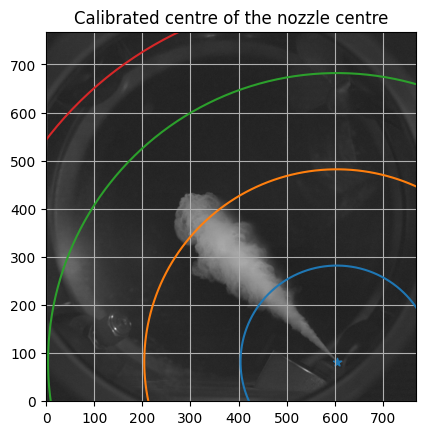

In [ ]:
rs = np.asarray([200, 400, 600, or_])

# Displaying the clibration
plt.imshow(_as_numpy(video[50]**0.5), cmap="gray")
plt.scatter(centre[0], centre[1], marker="*")

for r in rs:
    theta = np.linspace(0, 2*np.pi, 400)

    x0, y0 = centre[0] , centre[1]

    x = x0 + r * np.cos(theta)
    y = y0 + r * np.sin(theta)

    plt.plot(x, y, linewidth="1.5")


# plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
# plt.show()

plt.xlim([max(0, centre[0]-1.1*r), min(W, centre[0]+1.1*r)])
plt.ylim([max(0, centre[1]-1.1*r), min(H, centre[1]+1.1*r)])
plt.title("Calibrated centre of the nozzle centre")
centre

In [ ]:
# Rotation


# Frames, Height, Width
F, H, W = video.shape

# Image rotation settings
INTERPOLATION = "nearest"
BORDER_MODE = "constant"

# Arbitrary rotated image strip shape
OUT_SHAPE = (or_//3, or_)

video = cp.asarray(video)

segment, _, _ = rotate_video_nozzle_at_0_half_backend(
        video,
        centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
        # (centre[0] + np.cos(angle/180.0*xp.pi) * ir_, centre[1] + xp.sin(angle/180.0*np.pi) * ir_),
        offset,
        interpolation=INTERPOLATION,
        border_mode=BORDER_MODE,
        out_shape=OUT_SHAPE,
    )




In [ ]:
play_video_cv2(segment.get(), intv=17)
segment.shape

(401, 253, 760)

In [ ]:
# upload to gpu or do nothing with cpu

# pakaged pre-processing calling, use this in real impelmentations
# foreground = pre_processing_mie(video, division=False)

# Explicitly coding for showing the whole process

# We do not divide by the first frame to fix lighting
# In the videos I process, they have some strong bright spots by reflections
# If didivde, they become some dark spots. 


# For single plume, rotate & crop before filtering 

# Bilateral filtering
if use_gpu:
    bilateral_filtered = bilateral_filter_video_cupy(segment, 7, 3, 3)
else:
    bilateral_filtered = bilateral_filter_video_cpu(np.asarray(segment), 7, 3, 3)



# Take the filtered first frame as background 
bkg = bilateral_filtered[0]
bkg[bkg == 0] = 1e-9
bkg[bkg == cp.nan] = 1e-9

# Foreground is the filtered video - filtered background
foreground = bilateral_filtered - bilateral_filtered[0][None, :, :]
F, H, W = foreground.shape

In [ ]:
# play_video_cv2(foreground.get())

play_videos_side_by_side((
    cp.swapaxes(segment, 1, 2).get(),
    cp.swapaxes(foreground, 1, 2).get(),
    cp.swapaxes(10.0*cp.abs(foreground-segment), 1, 2).get()
), intv=17)
segment.shape

(401, 253, 760)

In [ ]:
td_map = xp.sum(foreground, axis=1).T
td_map.shape

(760, 401)

(760, 401)

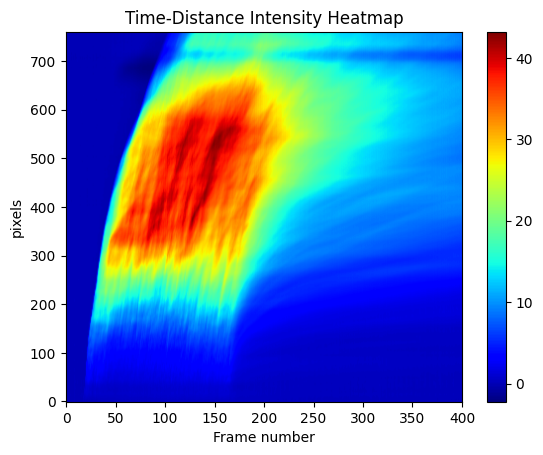

In [ ]:
plt.imshow(td_map.get(), origin="lower", aspect="auto", cmap="jet")
plt.title("Time-Distance Intensity Heatmap")
plt.colorbar()
plt.xlabel("Frame number")
plt.ylabel("pixels")
td_map.shape

In [ ]:
frame_wise_sums = xp.sum(td_map, axis=0)/td_map.shape[0]

brightness_peak = xp.argmax(frame_wise_sums)

peak_intensity_sum = xp.max(frame_wise_sums)


Text(0.5, 0, 'Frame Number')

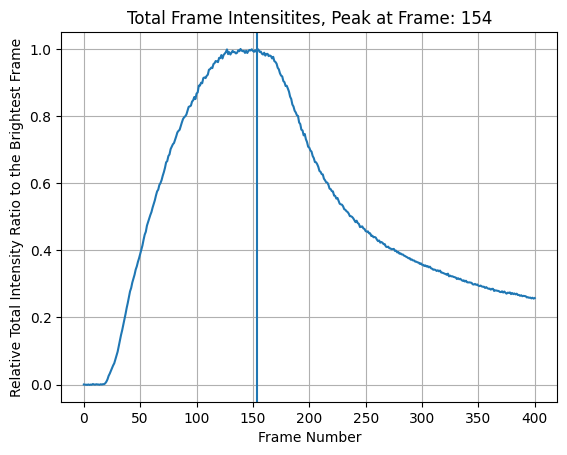

In [ ]:
ratio = frame_wise_sums.get()/peak_intensity_sum.get()
plt.plot(ratio)
plt.grid()
plt.axvline(brightness_peak.get())
plt.title(f"Total Frame Intensitites, Peak at Frame: {brightness_peak}")
plt.ylabel("Relative Total Intensity Ratio to the Brightest Frame")
plt.xlabel("Frame Number")


Text(0, 0.5, 'Gain')

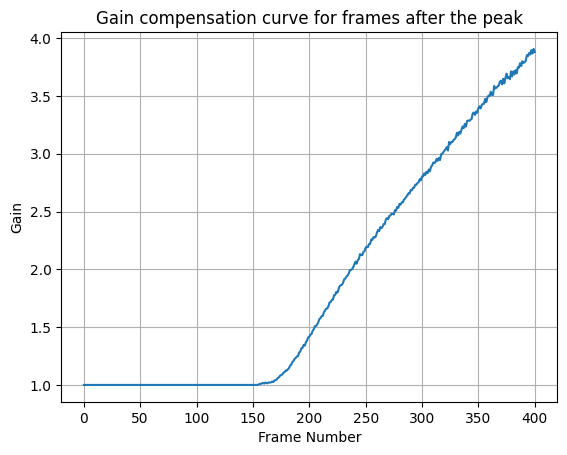

In [ ]:
gain_curve = 1.0 / (1e-9 + ratio.astype(xp.float64))

gain_curve[:int(brightness_peak)] = 1.0


plt.plot(gain_curve)
plt.title("Gain compensation curve for frames after the peak")
plt.grid()
plt.xlabel("Frame Number")
plt.ylabel("Gain")

In [ ]:
# foreground[int(brightness_peak):] *= xp.asarray(gain_curve[int(brightness_peak):, None, None])

# td_map[:, int(brightness_peak):] *= xp.asarray(gain_curve[None,  int(brightness_peak):])

In [ ]:
play_video_cv2(foreground.get())

(760, 401)

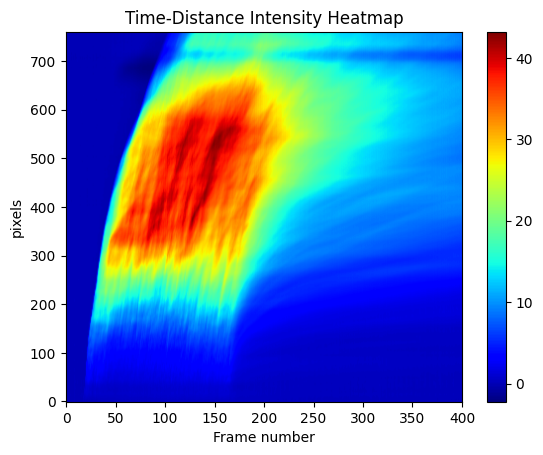

In [ ]:
plt.imshow(td_map.get(), origin="lower", aspect="auto", cmap="jet")
plt.title("Time-Distance Intensity Heatmap")
plt.colorbar()
plt.xlabel("Frame number")
plt.ylabel("pixels")
td_map.shape

In [ ]:
bw =  keep_largest_component_cuda(
        triangle_binarize_gpu(
            _min_max_scale(td_map))
            , connectivity=2)

Text(0.5, 0, 'Frame number')

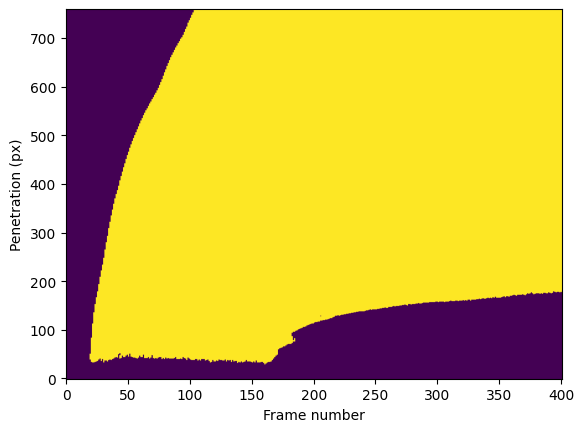

In [ ]:
plt.imshow(bw.get(), origin="lower", aspect="auto")
plt.ylabel("Penetration (px)")

plt.xlabel("Frame number")


In [ ]:
df = pd.DataFrame()

In [ ]:

penetration_TD = bw.shape[0] - cp.argmax(bw[::-1, :], axis=0)
penetration_TD = penetration_TD.astype(cp.float32)
penetration_TD[penetration_TD == bw.shape[0]] = cp.nan

TF = ~cp.isnan(penetration_TD)

start, end = longest_true_run(TF.get())

penetration_TD[:start] = 0.0
penetration_TD[end:] = cp.nan

df["Penetration_from_TD"] = penetration_TD.get()

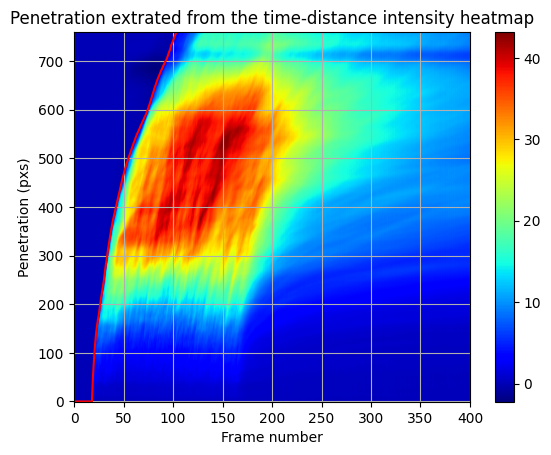

In [ ]:
plt.plot(penetration_TD.get(), color="r")
plt.imshow(td_map.get(), origin="lower", aspect="auto", cmap="jet")
plt.title("Penetration extrated from the time-distance intensity heatmap")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.colorbar()
plt.grid()

In [ ]:
# Cone angle
# We set the origin to the nozzle, and treat upper and lower half as two plumes
# Then calculate their cone angle by angular density respectively

_, signal, _ = angle_signal_density_auto(foreground, 0.0, H//2, N_bins=3600)
AngularDensity = compute_cone_angle_from_angular_density(signal, 0, 2, bins=3600, use_gpu=True)

# Upper & Lower cone angle, sums up to the total cone angle
cone_angle_AD_up = AngularDensity[0]
cone_angle_AD_down = AngularDensity[1]
cone_angle_AD = cone_angle_AD_up + cone_angle_AD_down
ad_up_np = to_numpy(cone_angle_AD_up)
ad_down_np = to_numpy(cone_angle_AD_down)

df["Cone_Angle_Angular_Density"] =cone_angle_AD
df["Cone_Angle_Angular_Density_Upper"] = ad_up_np
df["Cone_Angle_Angular_Density_Lower"] = ad_down_np



Text(0, 0.5, 'Frame number')

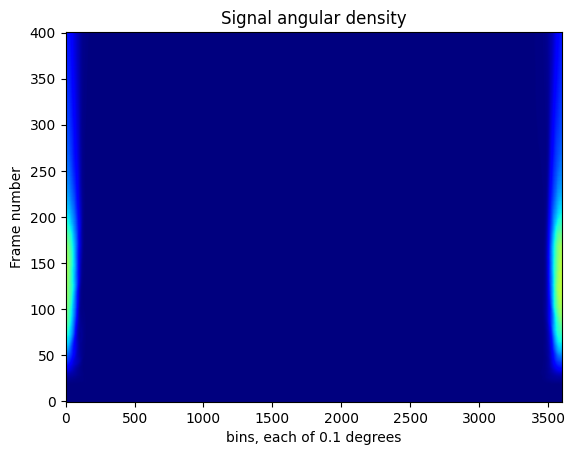

In [ ]:
bins = 3600
plt.imshow(signal, aspect="auto", origin="lower", cmap="jet")
plt.title("Signal angular density")
plt.xlabel(f"bins, each of {360.0/bins} degrees")
plt.ylabel("Frame number")

Text(0, 0.5, 'Cone Angle (Degrees)')

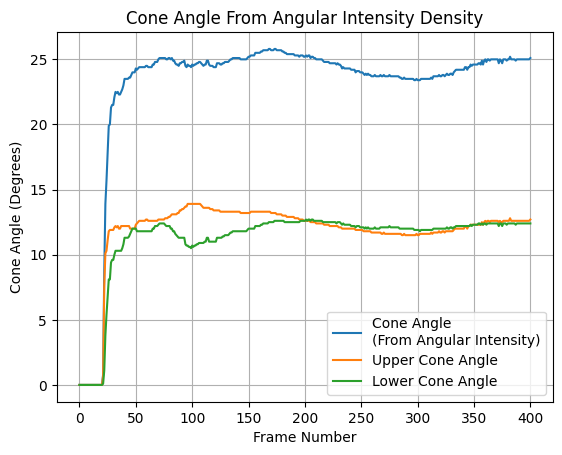

In [ ]:
plt.plot(cone_angle_AD, label="Cone Angle\n(From Angular Intensity)")
plt.plot(ad_down_np, label="Upper Cone Angle") 
plt.plot(ad_up_np, label="Lower Cone Angle")

plt.grid()
plt.title("Cone Angle From Angular Intensity Density")
plt.legend()
plt.xlabel("Frame Number")
plt.ylabel("Cone Angle (Degrees)")


In [ ]:
# Nozzle Opening and Closing

# Window Size in the left center of the video
height = 1.0/20
width = 1.0/20

F, H, W = segment.shape
near_nozzle_intensity_sums = xp.sum(segment[ :, int(H//2 - H*height//2):int(H//2 + H*height//2), :int(W*width)], axis=(1, 2))


In [ ]:
# play_video_cv2(segment[ :, int(H//2 - H*height//2):int(H//2 + H*height//2), :int(W*width)].get())

In [ ]:
Lo_Hi = cp.zeros_like(near_nozzle_intensity_sums, dtype=cp.bool_)

# num_cases, N = near_nozzle_intensity_sums.shape

# hydraulic_delay = np.zeros(num_cases, dtype=np.float32)
# nozzle_closing = np.zeros(num_cases, dtype=np.float32)


y =_min_max_scale( near_nozzle_intensity_sums.T.get() / (height* H * width*W)) # cupy -> numpy
res, mask, _ = detect_single_high_interval(y)

if res is None:
    hydraulic_delay = np.nan
    nozzle_closing = np.nan
    Lo_Hi[:] = False
else:    

    (hd, nc, _, _) = res   # 这里 hd/nc 是 x_start/x_end（如果你 x=None）
    hydraulic_delay = hd
    nozzle_closing = nc

    Lo_Hi = cp.asarray(mask, dtype=cp.bool_)

In [ ]:
df["Hydraulic_Delay"] = hydraulic_delay
df["Nozzle Closing"] = nozzle_closing


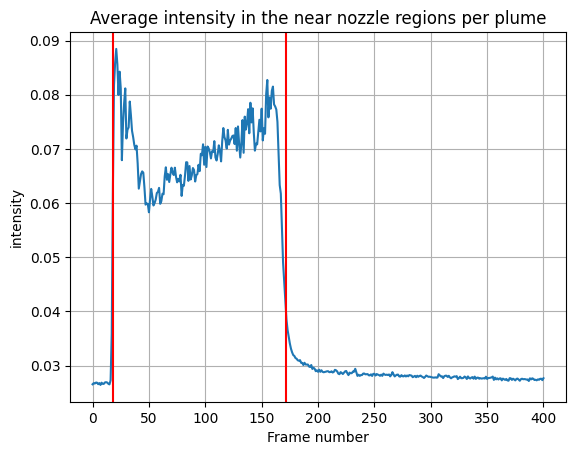

In [ ]:
plt.plot(near_nozzle_intensity_sums.T.get() / (height* H * width*W))
plt.axvline(hd.get().item(), color="r")
plt.axvline(nc.get().item(), color="r")
plt.title("Average intensity in the near nozzle regions per plume")
plt.xlabel("Frame number")
plt.ylabel("intensity")
plt.grid()

In [ ]:
df.head()

,Penetration_from_TD,Cone_Angle_Angular_Density,Cone_Angle_Angular_Density_Upper,Cone_Angle_Angular_Density_Lower,Hydraulic_Delay,Nozzle Closing
0,0.0,0.0,0.0,0.0,18,172
1,0.0,0.0,0.0,0.0,18,172
2,0.0,0.0,0.0,0.0,18,172
3,0.0,0.0,0.0,0.0,18,172
4,0.0,0.0,0.0,0.0,18,172


In [ ]:
bw_video = _binary_fill_holes_gpu(
    keep_largest_component_nd_cuda(
        triangle_binarize_gpu(foreground)
        , connectivity=2),
        mode="2D"
    )


In [ ]:
play_video_cv2(((1-bw_video)*segment).get()*10.0)


In [ ]:
area = bw_video.sum(axis=(1, 2))


bw_video_col_sum = bw_video.sum(axis=1)


penetration_bw_x = penetration_bw_to_index(bw_video_col_sum > 0)



In [ ]:
# Volume estimation

if umbrella_angle == 180.0:
    x_scale=1.0
else:
    tilt_angle = (180.0-umbrella_angle)/2.0
    tilt_angle_rad = tilt_angle / 180.0 * np.pi
    x_scale = 1.0/np.cos(tilt_angle_rad)

estimated_volume = x_scale * 0.25 * np.pi * np.sum(bw_video_col_sum**2, axis=1)

upper_bw_width = bw_video[:, : H // 2, :].sum(axis=1)
lower_bw_width = bw_video[:, H // 2 :, :].sum(axis=1)

max_plume_radius = np.maximum(upper_bw_width, lower_bw_width)
min_plume_radius = np.minimum(upper_bw_width, lower_bw_width)

estimated_volume_max =  x_scale * np.sum(np.pi * max_plume_radius**2, axis=1)
estimated_volume_min =  x_scale * np.sum(np.pi * min_plume_radius**2, axis=1)


In [ ]:
# from OSCC_postprocessing.analysis.single_plume import bw_boundaries_all_points_single_plume
def _boundary_points_one_frame(bw, connectivity=2, x_scale=1.0):
    """
    Compute all boundary points of a single binary frame without x-band filtering.

    Returns: (coords_top_all, coords_bottom_all) as (N,2) int32 arrays (y, x).
    """
    H, W = bw.shape 
    struct = generate_binary_structure(2, 2 if connectivity == 2 else 1)
    boundary = bw & ~binary_erosion(bw, structure=struct, border_value=0)
    if not boundary.any():
        return (np.empty((0, 2), dtype=np.int32), np.empty((0, 2), dtype=np.int32))

    ys, xs = np.nonzero(boundary)
    if ys.size == 0:
        return (np.empty((0, 2), dtype=np.int32), np.empty((0, 2), dtype=np.int32))

    mid = (H - 1) / 2.0
    top_mask = ys <= mid
    bot_mask = ~top_mask

    mid_val = np.asarray(mid, dtype=ys.dtype)

    ys -= mid_val   # Centering to 0
    xs = x_scale*xs.astype(np.float16)   # Correction by linear projection 

    coords_top = np.column_stack((ys[top_mask], xs[top_mask])) # .astype(np.int32)
    coords_bot = np.column_stack((ys[bot_mask], xs[bot_mask])) # .astype(np.int32)
    return coords_top, coords_bot

In [ ]:

def bw_boundaries_all_points_single_plume(bw_vid, connectivity=2, parallel=True, max_workers=None, umbrella_angle=180.0):
    """
    Compute all boundary points for a single BW video (F, H, W).

    - Accepts NumPy or CuPy input; GPU inputs are copied to CPU for boundary extraction.
    - Returns a list length F of tuples (coords_top_all, coords_bottom_all) with int32 coords.
    """
    cp = _get_cupy()
    if cp is not None and hasattr(bw_vid, "__cuda_array_interface__"):
        bw_cpu = cp.asnumpy(bw_vid)
    else:
        bw_cpu = np.asarray(bw_vid)

    F, H, W = bw_cpu.shape
    result = [None] * F
    if umbrella_angle == 180.0:
        x_scale=1.0
    else:
        tilt_angle = (180.0-umbrella_angle)/2.0
        tilt_angle_rad = tilt_angle / 180.0 * np.pi
        x_scale = 1.0/np.cos(tilt_angle_rad)


    def work(j):
        bw = np.asarray(bw_cpu[j], dtype=bool)
        return j, _boundary_points_one_frame(bw, connectivity, x_scale=x_scale)

    if parallel:
        if max_workers is None:
            max_workers = max(1, os.cpu_count() - 1)
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            futs = [ex.submit(work, j) for j in range(F)]
            for fut in as_completed(futs):
                j, tup = fut.result()
                result[j] = tup
    else:
        for j in range(F):
            _, tup = work(j)
            result[j] = tup

    return result

In [ ]:

boundary = bw_boundaries_all_points_single_plume(bw_video, parallel=True)

boundary

[(array([], shape=(0, 2), dtype=int32), array([], shape=(0, 2), dtype=int32)),
 (array([], shape=(0, 2), dtype=int32), array([], shape=(0, 2), dtype=int32)),
 (array([], shape=(0, 2), dtype=int32), array([], shape=(0, 2), dtype=int32)),
 (array([], shape=(0, 2), dtype=int32), array([], shape=(0, 2), dtype=int32)),
 (array([], shape=(0, 2), dtype=int32), array([], shape=(0, 2), dtype=int32)),
 (array([], shape=(0, 2), dtype=int32), array([], shape=(0, 2), dtype=int32)),
 (array([], shape=(0, 2), dtype=int32), array([], shape=(0, 2), dtype=int32)),
 (array([], shape=(0, 2), dtype=int32), array([], shape=(0, 2), dtype=int32)),
 (array([], shape=(0, 2), dtype=int32), array([], shape=(0, 2), dtype=int32)),
 (array([], shape=(0, 2), dtype=int32), array([], shape=(0, 2), dtype=int32)),
 (array([], shape=(0, 2), dtype=int32), array([], shape=(0, 2), dtype=int32)),
 (array([], shape=(0, 2), dtype=int32), array([], shape=(0, 2), dtype=int32)),
 (array([], shape=(0, 2), dtype=int32), array([], sh

Text(0.5, 1.0, 'Scattered boundary points at slected frames')

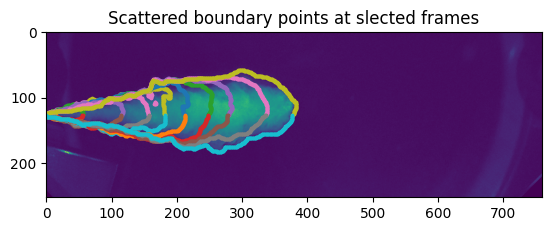

In [ ]:
selected_frames = [17, 19, 21, 23, 25, 27, 30, 32, 36, 40]
plt.imshow(segment[selected_frames[-1]].get())

F, H, W = foreground.shape

for f in selected_frames:
    # print(boundary[f])
    up = boundary[f][0]
    down = boundary[f][1]

    plt.scatter(up[:, 1], up[:, 0]+ H//2, s=3)
    plt.scatter(down[:, 1], down[:, 0]+ H//2, s=3)


# plt.xlim([0, W])
# plt.ylim([-H//2, H//2])

plt.title(f"Scattered boundary points at slected frames")


In [ ]:
penetration_old_polar = np.zeros(F)
for i in range(F):
    pts = boundary[i]
    if len(pts[0]) > 0 and len(pts[1]) > 0:

        uy, ux = pts[1][:, 0], pts[1][:, 1]
        ly, lx = pts[0][:, 0], pts[0][:, 1]

        max_r_upper = np.max(np.sqrt(uy**2 + ux**2))
        max_r_lower = np.max(np.sqrt(ly**2 + lx**2))
        penetration_old_polar[i] = max(max_r_upper, max_r_lower)

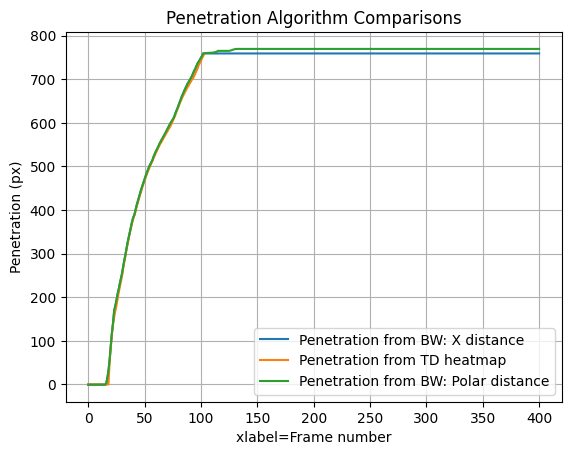

In [ ]:
plt.plot(penetration_bw_x.get(), label="Penetration from BW: X distance")
plt.plot(penetration_TD.get(), label="Penetration from TD heatmap")
plt.plot(penetration_old_polar, label="Penetration from BW: Polar distance")
plt.title("Penetration Algorithm Comparisons")
plt.xlabel("xlabel=Frame number")
plt.ylabel("Penetration (px)")
plt.grid()
plt.legend()


In [ ]:
points_all_frames = bw_boundaries_xband_filter_single_plume(boundary, penetration_bw_x.get())


Text(0.5, 1.0, 'Scattered boundary points at slected frames')

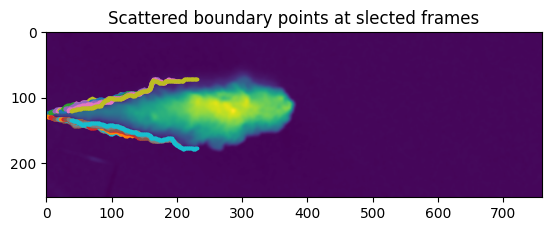

In [ ]:
plt.imshow(foreground[selected_frames[-1]].get())

for f in selected_frames:
    up = points_all_frames[f][0]
    down = points_all_frames[f][1]
    # print(up)
    plt.scatter(up[:, 1], up[:, 0]+ H//2, s=3)
    plt.scatter(down[:, 1], down[:, 0]+ H//2, s=3)


# plt.xlim([0, W])
# plt.ylim([-H//2, H//2])

plt.title(f"Scattered boundary points at slected frames")

In [ ]:
cone_angle_linear_regression = np.full(F, np.nan)
cone_angle_ransac = np.full(F, np.nan)
cone_angle_average = np.full(F, np.nan)
avg_up = np.full(F, np.nan)
avg_low = np.full(F, np.nan)
ransac_up = np.full(F, np.nan)
ransac_low = np.full(F, np.nan)
lg_up = np.full(F, np.nan)
lg_low = np.full(F, np.nan)

for i in range(F):
    points = points_all_frames[i]
    if len(points[0]) > 0 and len(points[1]) > 0:
        uy, ux = points[1][:, 0], points[1][:, 1]
        ly, lx = points[0][:, 0], points[0][:, 1]

        # uy -= H // 2
        # ly -= H // 2

        ang_up = np.atan(uy / ux) * 180.0 / np.pi
        ang_low = np.atan(ly / lx) * 180.0 / np.pi

        avg_up[i] = np.nanmean(ang_up)
        avg_low[i] = np.nanmean(ang_low)
        cone_angle_average[i] = avg_up[i]-  avg_low[i]

        try:
            ransac_up[i] = np.atan(ransac_fixed_intercept(ux, uy, 0)[0]) * 180.0 / np.pi
            ransac_low[i] = np.atan(ransac_fixed_intercept(lx, ly, 0)[0]) * 180.0 / np.pi
            cone_angle_ransac[i] = ransac_up[i] - ransac_low[i]
        except RuntimeError:
            pass

        try:
            lg_up[i] = np.atan(linear_regression_fixed_intercept(ux, uy, 0.0)) * 180.0 / np.pi
            lg_low[i] = np.atan(linear_regression_fixed_intercept(lx, ly, 0.0)) * 180.0 / np.pi
            cone_angle_linear_regression[i] = lg_up[i] - lg_low[i]
        except ValueError:
            pass

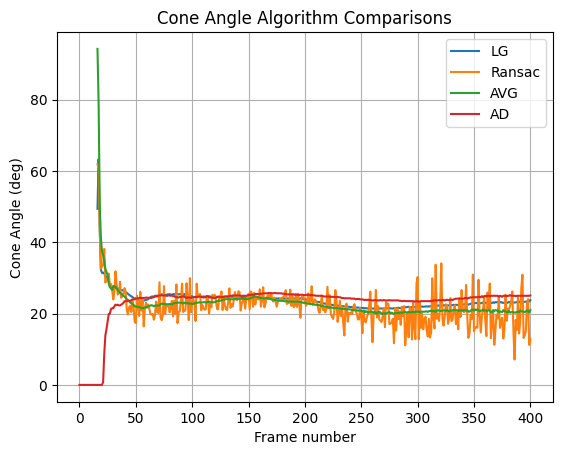

In [ ]:
plt.plot(cone_angle_linear_regression, label="LG")
plt.plot(cone_angle_ransac, label="Ransac")
plt.plot(cone_angle_average, label="AVG")
plt.plot(cone_angle_AD, label="AD")
plt.title("Cone Angle Algorithm Comparisons")
plt.xlabel("Frame number")
plt.ylabel("Cone Angle (deg)")
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Area')

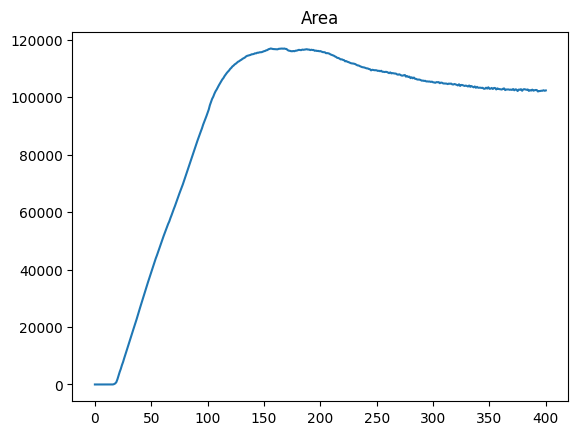

In [ ]:
plt.plot(area.get())
plt.title("Area")

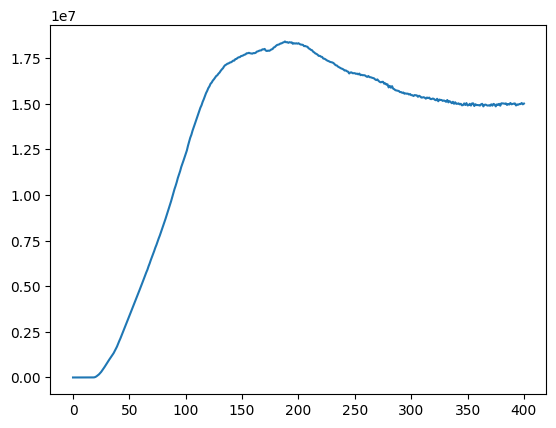

In [ ]:
plt.plot(estimated_volume.get())

In [ ]:

def mie_preprocessing(
    video,
    centre,
    rotation_offset,
    video_strip_relative_height=1.0 / 3,
    INTERPOLATION="nearest",
    BORDER_MODE="constant",
    wsize=7,
    sigma_d=3.0,
    sigma_r=3.0,
    blank_frames=10,
    outer_radius=None,
    preview=True,
):
    
    # 3D grayscale Numpy array
    F0 = video.shape[0]

    if outer_radius is None:
        outer_radius = globals().get("or_")
    if outer_radius is None:
        raise ValueError("outer_radius must be provided or set as global 'or_'.")

    out_h = int(round(float(video_strip_relative_height) * float(outer_radius)))
    out_h = max(1, out_h)
    out_w = int(round(float(outer_radius)))
    if out_w <= 0:
        raise ValueError("outer_radius must be positive.")

    blank_frames = max(1, min(int(blank_frames), F0))

    # Arbitrary rotated image strip shape
    OUT_SHAPE = (out_h, out_w)

    use_gpu = USING_CUPY
    if use_gpu:
        try:
            # Upload to GPU 
            # video_cp = cp.asarray(video)
            segment, _, _ = rotate_video_nozzle_at_0_half_backend(
                video,
                centre,
                rotation_offset,
                interpolation=INTERPOLATION,
                border_mode=BORDER_MODE,
                out_shape=OUT_SHAPE,
            )
        except Exception as exc:  # pragma: no cover - hardware dependent
            print(f"GPU rotation failed ({exc}), falling back to CPU numpy implementation.")
            use_gpu = False
    if not use_gpu:
        segment = _rotate_align_video_cpu(
            to_numpy(video),
            centre,
            rotation_offset,
            interpolation=INTERPOLATION,
            border_mode=BORDER_MODE,
            out_shape=OUT_SHAPE,
            cval=0.0,
        )

    # Bilateral filtering
    if use_gpu:
        bilateral_filtered = bilateral_filter_video_cupy(segment, wsize, sigma_d, sigma_r)
    else:
        bilateral_filtered = bilateral_filter_video_cpu(np.asarray(segment), wsize, sigma_d, sigma_r)
    xp = cp if use_gpu else np

    # Background subtraction
    # Take the filtered first frames as background
    bkg = xp.mean(bilateral_filtered[:blank_frames], axis=0, keepdims=True)

    eps = xp.asarray(1e-9, dtype=bkg.dtype)
    bkg = xp.where(bkg == 0, eps, bkg)
    bkg = xp.where(xp.isnan(bkg), eps, bkg)

    # Foreground is the filtered video - filtered background
    foreground = bilateral_filtered - bkg

    if preview:
        play_videos_side_by_side(
            (
                _as_numpy(xp.swapaxes(segment, 1, 2)),
                _as_numpy(xp.swapaxes(foreground, 1, 2)),
                _as_numpy(xp.swapaxes(10.0 * xp.abs(foreground - segment), 1, 2)),
            ),
            intv=17,
        )

    return segment, foreground, bkg

In [ ]:
# Testing pre-processing
segment, foregroud, background = mie_preprocessing(video, centre, offset, outer_radius=or_, preview=True)



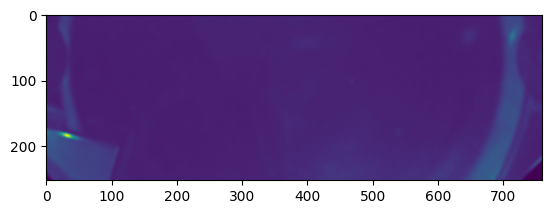

In [ ]:
plt.imshow(background.get().squeeze())


In [ ]:
def mie_single_hole_pipeline(video: xp.ndarray, file_name: str, 
                             centre, rotation_offset: float, inner_radius: float, outer_radius: float, 
                             video_out_dir: Path, data_out_dir: Path,
                             umbrella_angle = 180.0, # Single Plume has 0 deg of tilt angle (spary axis is orthogonal to line of sight)
                             video_strip_relative_height = 1.0/3, # Relative ratio of the rotated video strip to calibrated outer radius
                             INTERPOLATION = "nearest" ,BORDER_MODE = "constant", # image rotation settings
                             save_video_strip=True, save_mode ="filtered", # filtered rotated strip or raw
                             near_nozzle_relative_height = 1.0/20, near_nozzle_relative_width = 1.0/20, # Image patch sizes relative to the video strip after rotation and crop
                             solver="full", # "full" or "fast", where "full" mode computes also from binarized video
                             preview=False
                            ): 
    

    if preview:
        # Debug inputs
        print("Processing Cine file: ", file_name)
        print("Video has shape: ", video.shape)
        print("Nozzle centred at: ", centre[0], centre[1])
        print("Degrees of rotation:", rotation_offset)
        print("Saving rotated video strip to directory: ", video_out_dir)
        print("Saving data to directory: ", data_out_dir)
    
    if USING_CUPY:
        if isinstance(video, cp.ndarray):
            pass
        if isinstance(video, np.ndarray):
            
            video = cp.asarray(video)
        # return "numpy.ndarray (CPU)"

    start_time = time.time()

    # Rotation + Filtering + Background Subtraction
    segment, foreground, background = mie_preprocessing(video, centre, offset, outer_radius=or_, preview=False)

    print(f"Preprocessing finished in {time.time()-start_time:.2} s")
    F, H, W = foreground.shape


    # Optionally save the rotated video as .npz or .avi for visualization
    if save_video_strip==True:
        avi_saver = AsyncAVISaver()
        npz_saver = AsyncNPZSaver()
        if save_mode == "raw": 
            npz_saver.save(video_out_dir / f"{file_name}_rotated_strip.npz", segment=_as_numpy(segment))
            avi_saver.save(
                video_out_dir / f"{file_name}_rotated_strip.avi",
                _as_numpy(segment),
                fps=20,
                is_color=False,
                auto_normalize=True,
            )
        elif save_mode=="filtered":
            npz_saver.save(data_out_dir / f"{file_name}_foreground.npz", foreground=_as_numpy(foreground))
            avi_saver.save(
                data_out_dir / f"{file_name}_foreground.avi",
                _as_numpy(foreground),
                fps=10,
                is_color=False,
                auto_normalize=True,
            )



    # Nozzle Closing and Opening time

    # Nozzle Opening and Closing

    # Window Size in the left center of the video

    near_nozzle_video_patch = foreground[:, 
                                         int(H//2 - H*near_nozzle_relative_height//2):int(H//2 + H*near_nozzle_relative_height//2), 
                                         :int(W*near_nozzle_relative_width)
                                         ]
    near_nozzle_intensity_sums = xp.sum(near_nozzle_video_patch, axis=(1, 2))


    Lo_Hi = cp.zeros_like(near_nozzle_intensity_sums, dtype=cp.bool_)


    y =_min_max_scale( near_nozzle_intensity_sums.T) # cupy -> numpy
    res, mask, _ = detect_single_high_interval(y)

    if res is None:
        hydraulic_delay = np.nan
        nozzle_closing = np.nan
        Lo_Hi[:] = False
    else:    

        (hd, nc, _, _) = res   # 这里 hd/nc 是 x_start/x_end（如果你 x=None）
        hydraulic_delay = hd.get().item()
        
        # Shifting hydraulic delay by 1 frame 
        hd -= 1
        hydraulic_delay -= 1 
        
        nozzle_closing = nc.get().item()

        Lo_Hi = cp.asarray(mask, dtype=cp.bool_)
    
        
    # print("Hydraulic delay:", hd)
    # print("Nozzle closing:", nc)



    # Time-Distance Intensity Map
    td_map = 1.0/H * xp.sum(foreground, axis=1).T

    if preview:
        plt.imshow(_as_numpy(td_map), origin="lower", aspect="auto", cmap="jet")
        plt.title("Time-Distance Intensity Heatmap")
        plt.colorbar()
        plt.xlabel("Frame number")
        plt.ylabel("pixels")
        plt.axvline(hydraulic_delay, label="Hydraulic Delay", color="r")
        plt.axvline(nozzle_closing, label="Nozzle Closing", color="k")
        plt.legend()
        plt.show()

    # Find average pixel intensity in each frame
    average_pixel_intensity = 1.0/ W* xp.sum(td_map, axis=0)

    # Find the largest 
    brightness_peak = xp.argmax(average_pixel_intensity)

    # Find the frame where the average intensity is the largest
    peak_intensity_sum = xp.max(average_pixel_intensity)

    # Ratio of average intensity of each frame against the brightest frame
    ratio = average_pixel_intensity/peak_intensity_sum

    if preview:
        plt.plot(_as_numpy(ratio))
        plt.grid()
        plt.axvline(_as_numpy(brightness_peak))
        plt.title(f"Total Frame Intensitites, Peak at Frame: {_as_numpy(brightness_peak)}")
        plt.ylabel("Relative Total Intensity Ratio to the Brightest Frame")
        plt.xlabel("Frame Number")
        plt.axvline(hydraulic_delay, label="Hydraulic Delay", color="r")
        plt.axvline(nozzle_closing, label="Nozzle Closing", color="k")
        plt.legend()
        plt.show() 

    # Compute a gain correction using the 1/ratio, ratio needs to += epsilon to avoid overflow
    eps = 1e-9
    gain_curve = 1.0 / (eps + ratio.astype(xp.float64))

    gain_curve[:int(brightness_peak)] = 1.0

    if preview: 
        plt.plot(_as_numpy(gain_curve))
        plt.axvline(_as_numpy(brightness_peak))
        plt.title("Gain compensation curve for frames after the peak")
        plt.grid()
        plt.xlabel("Frame Number")
        plt.ylabel("Gain")
        plt.show()
    
    # Gain correction for frames after the brightest frame, so pixels with lower value won't 
    # Be binarized as 0, therefore improving accuracy

    # Gain correction for the time-distance intensity map
    td_map[:, int(brightness_peak):] *= xp.asarray(gain_curve[None,  int(brightness_peak):])
    
    df = pd.DataFrame()

    if use_gpu:
        # Compute the penetration by binarizing the gain-corrected, time-distance intensity map

        # Min-Max scale, triangular binarize, then keep the largest component (AKA connected area in 2D)
        bw =  keep_largest_component_cuda(
                    triangle_binarize_gpu(
                    _min_max_scale(td_map))
                    , connectivity=2)
        
        # Find the left edge as penetration curve
        penetration_TD = bw.shape[0] - cp.argmax(bw[::-1, :], axis=0)
        penetration_TD = penetration_TD.astype(cp.float32)
        penetration_TD[penetration_TD == bw.shape[0]] = cp.nan

        # Mask
        TF = ~cp.isnan(penetration_TD)

        # Find the longest sub-sequence that is non-nan
        start, end = longest_true_run(TF.get())

        # Reset the penetration before SOI to 0.0
        penetration_TD[:start] = 0.0
        # Reset the penetration after saturation to nan
        penetration_TD[end:] = cp.nan
    else:
        # TODO: implement an efficient CPU version
        raise NotImplementedError

    if preview:
        plt.plot(_as_numpy(penetration_TD), color="r")
        plt.imshow(_as_numpy(td_map), origin="lower", aspect="auto", cmap="jet")
        plt.title("Penetration extrated from the time-distance intensity heatmap")
        plt.xlabel("Frame number")
        plt.ylabel("Penetration (pxs)")
        plt.axvline(hydraulic_delay, label="Hydraulic Delay", color="r")
        plt.axvline(nozzle_closing, label="Nozzle Closing", color="k")
        plt.legend()
        plt.colorbar()
        plt.grid()
        plt.show()
    
    # Cone angle

    # We set the origin to the nozzle, and treat upper and lower half as two plumes
    # Then calculate their cone angle by angular density respectively

    accuracy = 0.1 # degrees

    n_bins = int(360.0/accuracy)
    _, signal, _ = angle_signal_density_auto(foreground, 0.0, H//2, N_bins=n_bins)
    AngularDensity = compute_cone_angle_from_angular_density(signal, 0, 2, bins=n_bins, use_gpu=use_gpu)
 
    # Upper & Lower cone angle, sums up to the total cone angle
    cone_angle_AD_up    = AngularDensity[0]
    cone_angle_AD_down  = AngularDensity[1]

    # Cone angle is the sum of the two, since both are defined positive
    cone_angle_AD       = cone_angle_AD_up + cone_angle_AD_down

    if preview:
        plt.plot(_as_numpy(cone_angle_AD),     label="Total Cone Angle")
        plt.plot(_as_numpy(cone_angle_AD_down),        label="Upper Cone Angle") 
        plt.plot(_as_numpy(cone_angle_AD_up),          label="Lower Cone Angle")
        
        plt.grid()
        plt.title("Cone Angle From Angular Intensity Density")
    
        plt.axvline(hydraulic_delay, label="Hydraulic Delay", color="r")
        plt.axvline(nozzle_closing, label="Nozzle Closing", color="k")
        plt.legend()
        plt.xlabel("Frame Number")
        plt.ylabel("Cone Angle (Degrees)")

        plt.show()


    if solver=="full":

        if preview:
            fg_copy = foregroud.copy() 

        # Gain correction for the video
        foreground[int(brightness_peak):] *= xp.asarray(gain_curve[int(brightness_peak):, None, None])

        # Binarize the whole video with a global triangular threshold
        # Then retain the largest 3D blob 
        # (Reasoning: All bw area in each frame is assumed to be connected to the previous and the next, 
        # By sharing at least 1 common pixel. Therefore the spray should be one blob)
        # Finally, fill holes in each frame in 2D mode
        bw_video = _binary_fill_holes_gpu(
                        keep_largest_component_nd_cuda(
                        triangle_binarize_gpu(foreground)
                        , connectivity=2),
                        mode="2D"
                        )
        


        bw_video_col_sum = bw_video.sum(axis=1)

        area = bw_video_col_sum.sum(axis=-1)

        penetration_bw_x = penetration_bw_to_index(bw_video_col_sum > 0)

        boundary = bw_boundaries_all_points_single_plume(bw_video, parallel=True, umbrella_angle=180.0)


        # Estimate the volume

        if umbrella_angle == 180.0:
            x_scale=1.0
        else:
            tilt_angle = (180.0-umbrella_angle)/2.0
            tilt_angle_rad = tilt_angle / 180.0 * np.pi
            x_scale = 1.0/np.cos(tilt_angle_rad)

        # Volume is defined as:
        # Sum [1/4 * pi * diameter^2 * (1 pixel * x_scale unit length)]
        # In which the diameter is the width of binarized image every column per frame
        # estimated_volume = x_scale* 0.25 * np.pi * np.sum(bw_video_col_sum**2, axis=1)

        # Upper and lower half of the plume width
        upper_bw_width = bw_video[:, : H // 2, :].sum(axis=1)
        lower_bw_width = bw_video[:, H // 2 :, :].sum(axis=1)

        # accelerated version
        estimated_volume = x_scale * np.pi * 0.25 * np.sum((upper_bw_width + lower_bw_width) ** 2, axis=1)
        
        # Check per column the larger width and the smaller width
        max_plume_radius = np.maximum(upper_bw_width, lower_bw_width)
        min_plume_radius = np.minimum(upper_bw_width, lower_bw_width)

        # Use the previous to estimate 
        estimated_volume_max = np.pi * x_scale * np.sum(max_plume_radius**2, axis=1)
        estimated_volume_min = np.pi * x_scale * np.sum(min_plume_radius**2, axis=1)


        if preview:
            # Visualize the filtered video, it after gain correction, 
            # and the frame wise difference between these two
            play_videos_side_by_side(
                (
                    _as_numpy(xp.swapaxes(fg_copy, 1, 2)),
                    _as_numpy(xp.swapaxes(foreground, 1, 2)),
                    _as_numpy(xp.swapaxes(xp.abs(foreground - fg_copy), 1, 2)),
                ),
                intv=17,
            )
        
        penetration_bw_polar = np.zeros(F)
        for i in range(F):
            pts = boundary[i]
            if len(pts[0]) > 0 and len(pts[1]) > 0:

                uy, ux = pts[1][:, 0], pts[1][:, 1]
                ly, lx = pts[0][:, 0], pts[0][:, 1]

                max_r_upper = np.max(np.sqrt(uy**2 + ux**2))
                max_r_lower = np.max(np.sqrt(ly**2 + lx**2))
                penetration_bw_polar[i] = max(max_r_upper, max_r_lower)
    
        if preview:
            plt.plot(_as_numpy(penetration_bw_x), label="Penetration from BW: X distance")
            plt.plot(_as_numpy(penetration_TD), label="Penetration from TD heatmap")
            plt.plot(_as_numpy(penetration_bw_polar), label="Penetration from BW: Polar distance")
            plt.title("Penetration Algorithm Comparisons")
            plt.xlabel("xlabel=Frame number")
            plt.ylabel("Penetration (px)")
            plt.grid()
            plt.legend()
        
        # Filter boundary points per frame 
        points_all_frames = bw_boundaries_xband_filter_single_plume(boundary, penetration_bw_x.get())

        cone_angle_linear_regression = np.full(F, np.nan)
        lg_up = np.full(F, np.nan)
        lg_low = np.full(F, np.nan)

        cone_angle_average = np.full(F, np.nan)
        avg_up = np.full(F, np.nan)
        avg_low = np.full(F, np.nan)

        # cone_angle_ransac = np.full(F, np.nan)
        # ransac_up = np.full(F, np.nan)
        # ransac_low = np.full(F, np.nan)

        # start_time = time.time()
        for i in range(F):
            points = points_all_frames[i]
            if len(points[0]) > 0 and len(points[1]) > 0:
                uy, ux = points[1][:, 0], points[1][:, 1]
                ly, lx = points[0][:, 0], points[0][:, 1]

                ang_up = np.atan(uy / ux) * 180.0 / np.pi
                ang_low = np.atan(ly / lx) * 180.0 / np.pi

                avg_up[i] = np.nanmean(ang_up)
                avg_low[i] = np.nanmean(ang_low)
                


                try:
                    lg_up[i] = np.atan(linear_regression_fixed_intercept(ux, uy, 0.0)) * 180.0 / np.pi
                    lg_low[i] = np.atan(linear_regression_fixed_intercept(lx, ly, 0.0)) * 180.0 / np.pi
                    
                except ValueError:
                    pass

            cone_angle_average = avg_up -  avg_low
            cone_angle_linear_regression = lg_up - lg_low
        # print(f"Time taken for classical cone angle calculations: {time.time()-start_time}")

    # start_time = time.time()
    # Save penetration from the time-distance intensity map
    df["Penetration_from_TD"]                   = _as_numpy(penetration_TD)
    df["Cone_Angle_Angular_Density"]            = _as_numpy(cone_angle_AD)
    df["Cone_Angle_Angular_Density_Upper"]      = _as_numpy(cone_angle_AD_up)
    df["Cone_Angle_Angular_Density_Lower"]      = _as_numpy(cone_angle_AD_down)
    df["Hydraulic Delay"]                       = _as_numpy(hd)
    df["Nozzle Closing"]                        = _as_numpy(nc)

    if solver=="full":

        # Asynchronously saving the boundary
        executor = ThreadPoolExecutor(max_workers=4)
        save_boundary_csv(boundary, data_out_dir / f"{file_name}_boundary_points.csv", executor=executor)
        
        df["Penetration_from_BW"] = _as_numpy(penetration_bw_x)
        df["Penetration_from_BW_Polar"] = _as_numpy(penetration_bw_polar)
        df["Area"] = _as_numpy(area)
        df["Estimated_Volume"] = _as_numpy(estimated_volume)
        df["Estimated_Volume_Upper_Limit"] = _as_numpy(estimated_volume_max)
        df["Estimated_Volume_Lower_Limit"] = _as_numpy(estimated_volume_min)


        df["Cone_Angle_Average"] = _as_numpy(cone_angle_average)
        df["Cone_Angle_Average_Lower"] = _as_numpy(cone_angle_AD_down)
        df["Cone_Angle_Average_Upper"] = _as_numpy(cone_angle_AD_up)
        df["Cone_Angle_Linear_Regression"] = _as_numpy(cone_angle_linear_regression)
        df["Cone_Angle_Linear_Regression_Lower"] = _as_numpy(lg_low)
        df["Cone_Angle_Linear_Regression_Upper"] = _as_numpy(lg_up)


    # Save main data        
    df.to_csv(data_out_dir / f"{file_name}_metrics.csv")

    # print(f"DataFrame handling finished in {time.time()-start_time:.3f}s")

    # Shutting down the asynchrounous data savers
    if save_video_strip: 
        avi_saver.wait()
        avi_saver.shutdown()
        npz_saver.wait()
        npz_saver.shutdown()
    executor.shutdown(wait=True)
    return df
    
    

Processing Cine file:  T2_Mie Camera_1.cine
Video has shape:  (401, 768, 768)
Nozzle centred at:  604.0 82.0
Degrees of rotation: -135.0
Saving rotated video strip to directory:  G:\MeOH_test\Mie\Processed_Results\Rotated_Videos
Saving data to directory:  G:\MeOH_test\Mie\Processed_Results\Postprocessed_Data
Preprocessing finished in 1.6 s


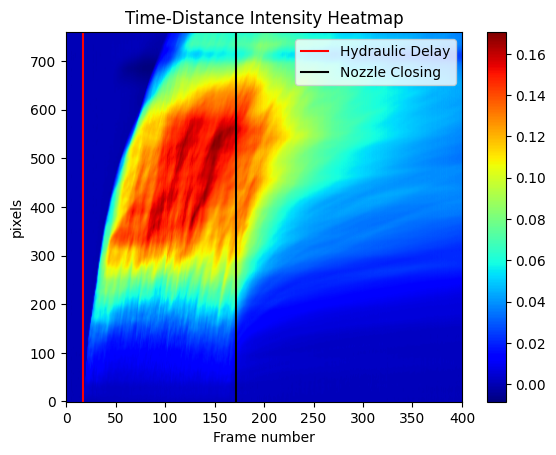

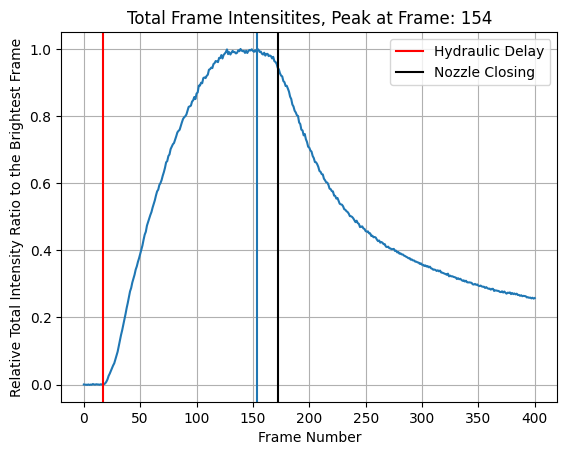

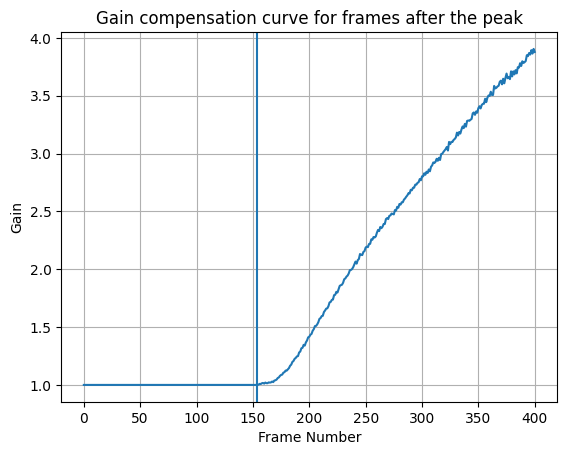

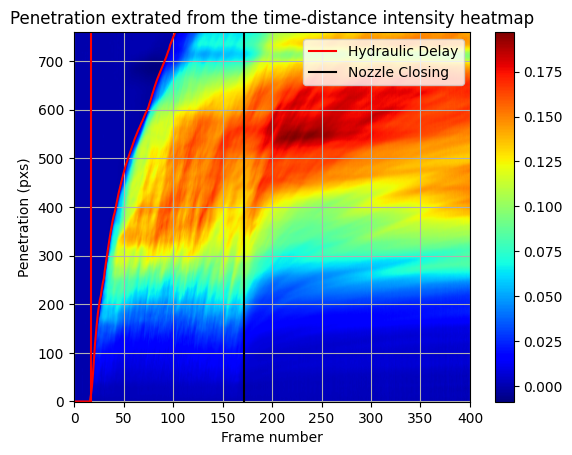

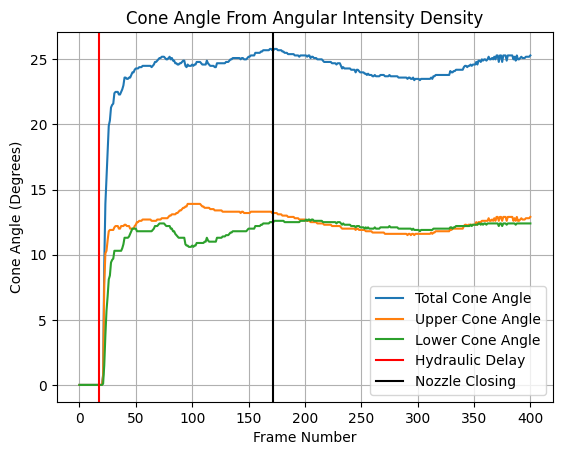

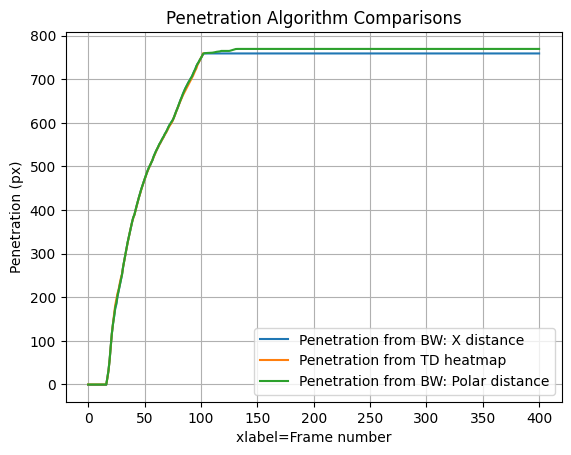

In [ ]:
df = mie_single_hole_pipeline(video, file.name, centre, offset, ir_, or_, save_path_video, save_path_data, save_video_strip=False, preview=True)


In [ ]:
df.columns

In [ ]:
plt.title("Estimated Volume")
plt.plot(df['Estimated_Volume_Upper_Limit'], label="upper limit")
plt.plot(df['Estimated_Volume'], label="mean")
plt.plot(df['Estimated_Volume_Lower_Limit'], label="lower limit")
plt.xlabel("Frame Number")
plt.ylabel("Volume (px^3)")
plt.legend()
plt.grid()

In [ ]:
plt.imshow(segment[18].get())